## 0.1 Build dataset of song syllables with their spectrograms


### This notebook does the following:
 - Segments songs into individual syllables
 - Creates spectrograms for each syllables
 - Saves a dataset to be used in furhter analyses
 

In [1]:
# Reload modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import seaborn as sns
import src

from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed

from src.greti.read.paths import DATA_DIR
from src.avgn.utils.paths import most_recent_subdirectory, ensure_dir
from src.avgn.utils.hparams import HParams
from src.avgn.dataset import DataSet
from src.avgn.signalprocessing.create_spectrogram_dataset import *

from src.avgn.visualization.spectrogram import draw_spec_set
from src.avgn.visualization.projections import (
    scatter_spec,
    scatter_projections,
    draw_projection_transitions,
)
from src.avgn.visualization.quickplots import draw_projection_plots
import umap


/home/nilomr/miniconda3/envs/0.2_great-tit-song-ml/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


### Select dataset and parameters
> Use output of the previous notebook (*_segmented)

In [3]:
DATASET_ID = "GRETI_HQ_2020_segmented"

n_jobs = -2
verbosity = 10

hparams = HParams(
    num_mel_bins=64,
    n_fft=1024,
    win_length_ms=15,
    hop_length_ms=3,
    mel_lower_edge_hertz=1200,
    mel_upper_edge_hertz=10000,
    butter_lowcut=1200,
    butter_highcut=10000,
    ref_level_db=30,
    min_level_db=-19,
    mask_spec=True,
    n_jobs=-2,
    verbosity=1,
    nex=-1,
)

In [4]:

# create a dataset object
dataset = DataSet(DATASET_ID, hparams=hparams)
dataset.sample_json
len(dataset.data_files)


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  43 tasks      | elapsed:    2.1s


[Parallel(n_jobs=-2)]: Done 1065 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-2)]: Done 1087 out of 1100 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 1100 out of 1100 | elapsed:    2.9s finished


1100

In [5]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain=[],
            key=key,
        )
        for key in tqdm(dataset.data_files.keys())
    )

syllable_df = pd.concat(syllable_dfs)
len(syllable_df)
syllable_df[:3]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0176s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0396s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1711s.) Setting batch_size=8.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1024s.) Setting batch_size=16.
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 450 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 658 tasks      | elapsed:    1.1s


[Parallel(n_jobs=-2)]: Done 898 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done 1003 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 1020 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 1037 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 1056 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done 1075 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done 1100 out of 1100 | elapsed:    1.7s finished


,start_time,end_time,indv,indvi,key
0,0.024,0.063,EX120,0,EX120-GRETI_HQ-20200426_040000-12.wav
1,0.291,0.378,EX120,0,EX120-GRETI_HQ-20200426_040000-12.wav
2,0.456,0.543,EX120,0,EX120-GRETI_HQ-20200426_040000-12.wav


### Get audio for dataset

In [6]:

with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key],
            dataset.data_files[key].data["wav_loc"],
            dataset.hparams,
        )
        for key in tqdm(syllable_df.key.unique(), position=0, leave=True)
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-2)]: Done 167 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   

[Parallel(n_jobs=-2)]: Done 1100 out of 1100 | elapsed:  1.3min finished


11151

### Normalise audio

In [7]:

df_mask = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])
syllable_df = syllable_df[np.array(df_mask)]
sylls = syllable_df.audio.values

syllable_df["audio"] = [librosa.util.normalize(i) for i in syllable_df.audio.values]
sylls = syllable_df["audio"].values


- Plot amplitude envelope of a few syllables

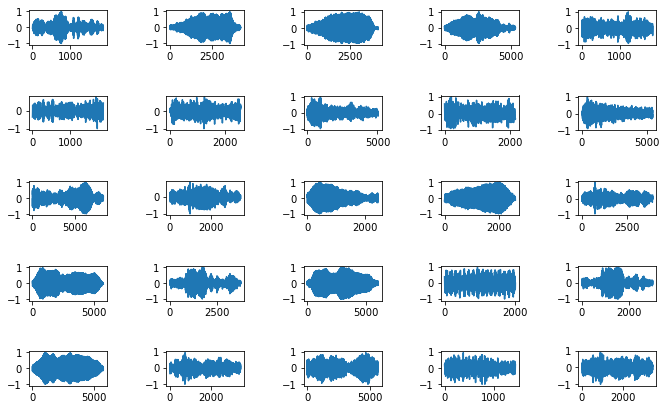

In [8]:
nrows = 5
ncols = 5
zoom = 2
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * zoom, nrows + zoom / 1.5)
)
for i, syll in tqdm(enumerate(sylls), total=nrows * ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows * ncols - 1:
        break

fig.tight_layout(pad=3.0)

### Create spectrograms

In [9]:

syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values


with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            position=0, 
            leave=True
        )
    )


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0062s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0310s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0345s.) Setting batch_size=8.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0527s.) Setting batch_size=16.
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0720s.) Setting batch_size=32.
[Parallel(n_jobs=-2)]: Done 242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 466 tasks      | elapsed:    0.4s
[Parallel(n

[Parallel(n_jobs=-2)]: Done 10098 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done 10744 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done 10918 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-2)]: Done 11043 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-2)]: Done 11138 out of 11151 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 11151 out of 11151 | elapsed:    5.7s finished


- Plot one example

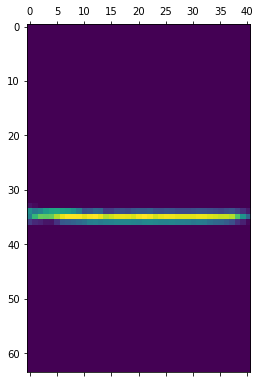

In [10]:
plt.matshow(syllables_spec[20])

### Rescale and pad spectrograms
> Rescaling removes duration differences, which you might not want 

In [11]:

# log_scaling_factor = 10

# with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
#     syllables_spec = parallel(
#         delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
#         for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
#     )


In [12]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)


with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(syllables_spec, desc="padding spectrograms", leave=False)
    )

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0066s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0171s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0183s.) Setting batch_size=8.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0249s.) Setting batch_size=16.
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0389s.) Setting batch_size=32.
[Parallel(n_jobs=-2)]: Done 242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 466 tasks      | elapsed:    0.2s
[Parallel(n

- Plot a few

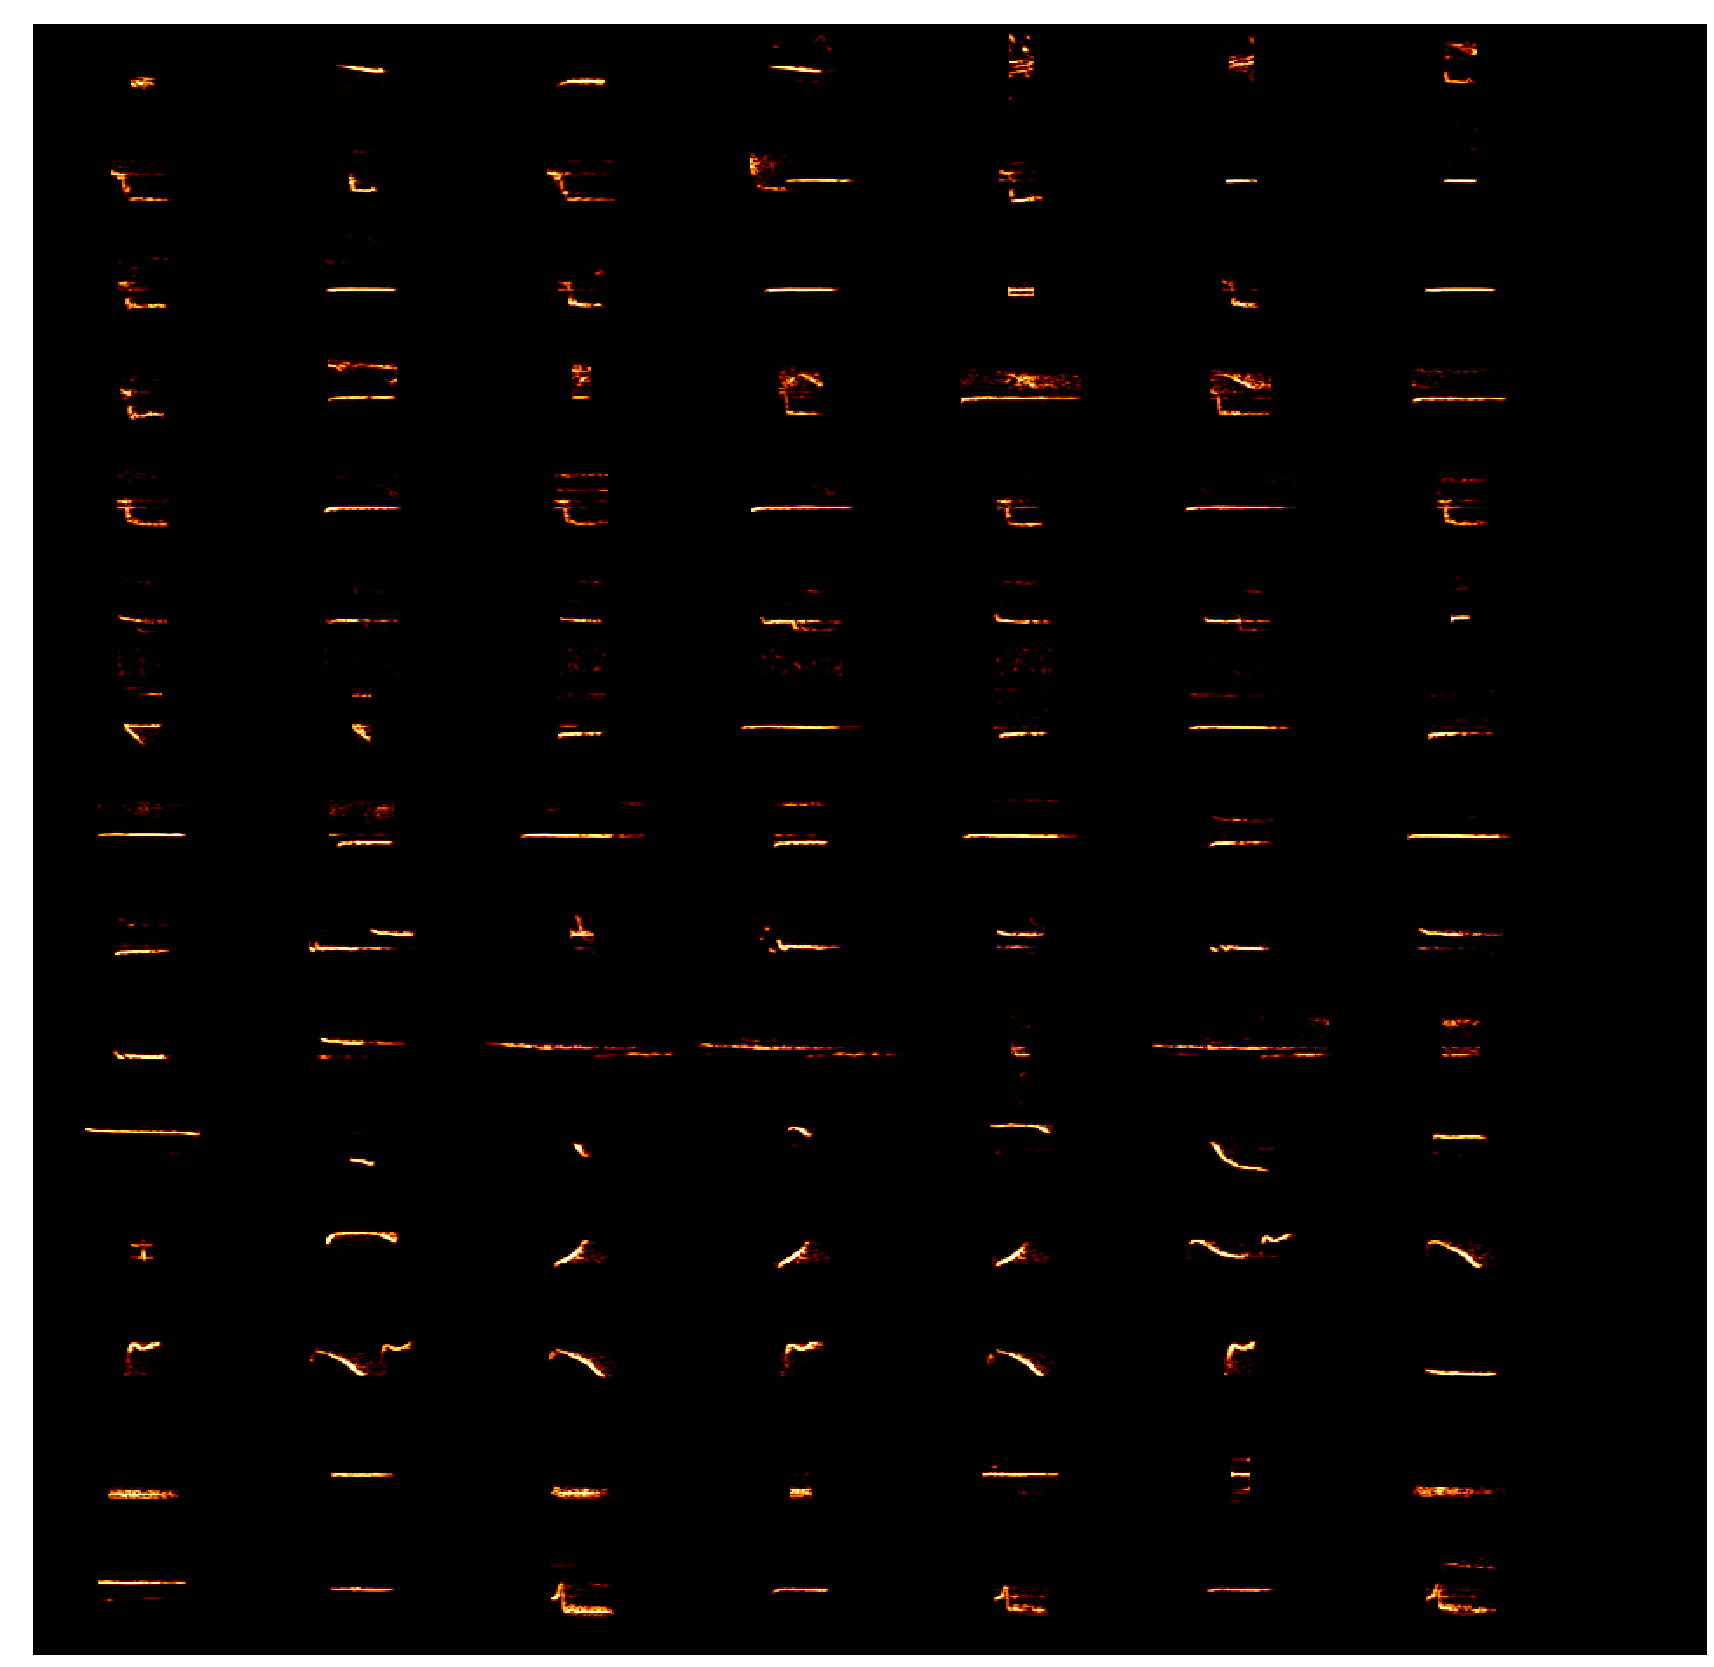

In [13]:
np.shape(syllables_spec)
draw_spec_set(syllables_spec, zoom=2, maxrows=15, colsize=15)

### Clip range and convert to uint8

In [14]:
# Clip range to add contrast
def contrast(x):
    minval = np.percentile(x, 5)
    maxval = np.percentile(x, 100)
    x = np.clip(x, minval, maxval)
    x = ((x - minval) / (maxval - minval)) * 255
    return x

syllables_spec = [contrast(i).astype("uint8") for i in tqdm(syllables_spec)]
syllable_df["spectrogram"] = syllables_spec


### Plot a few sylables per individual

B175 650


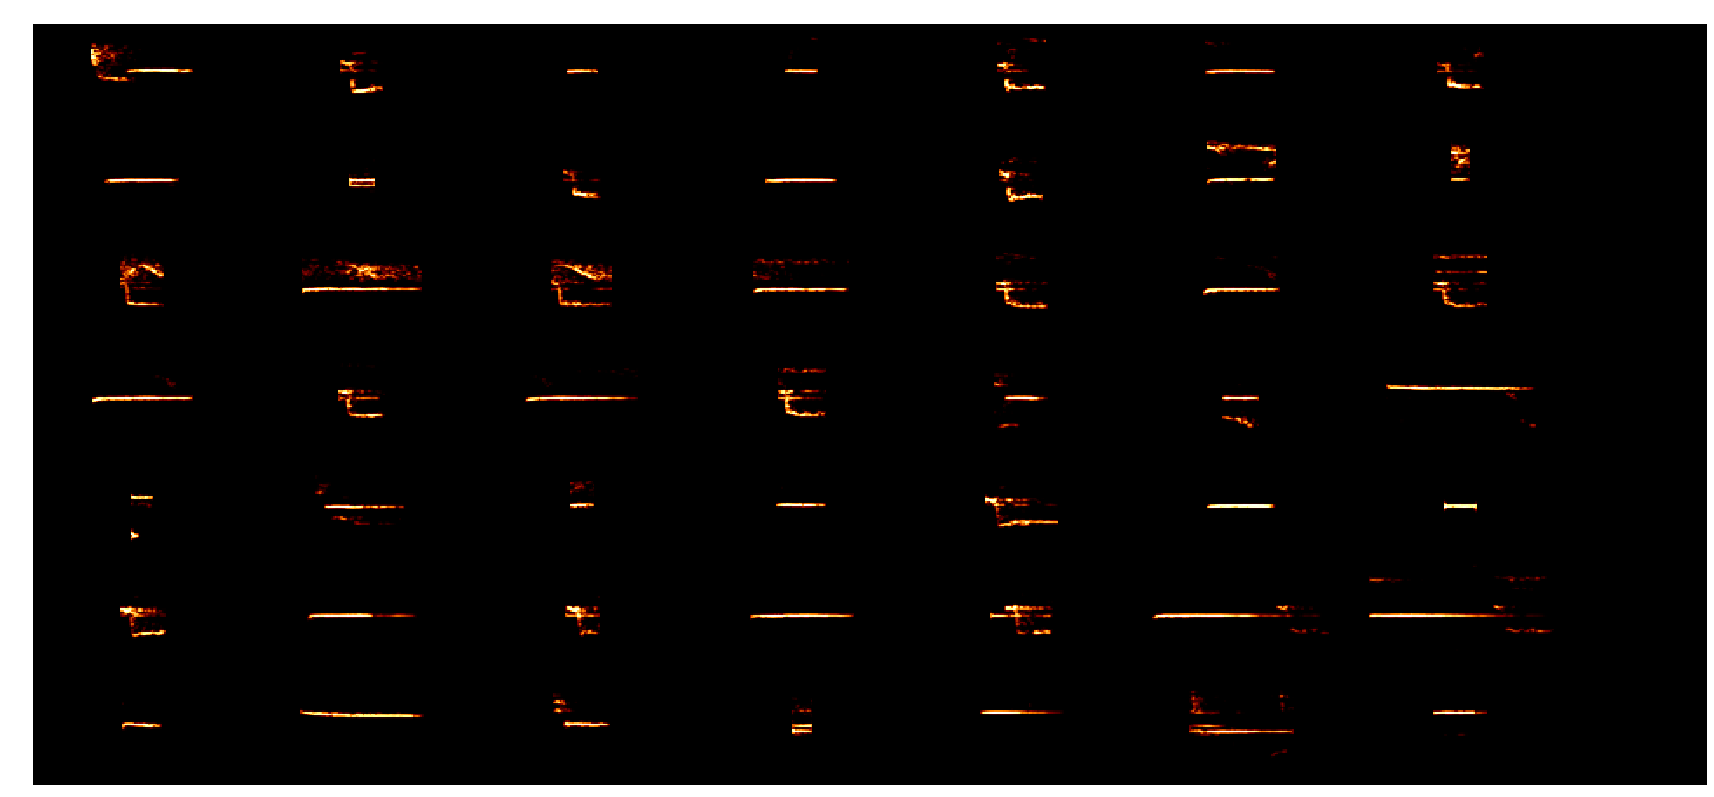

B181 14


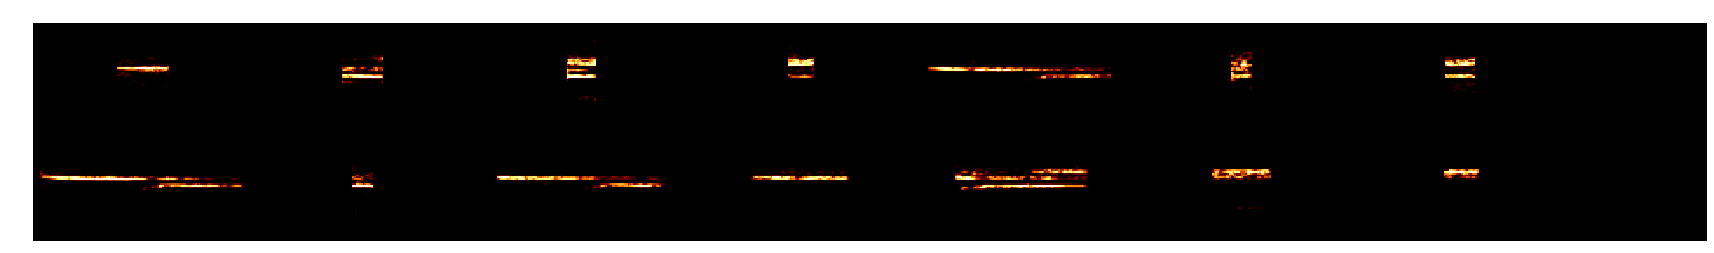

C126 10


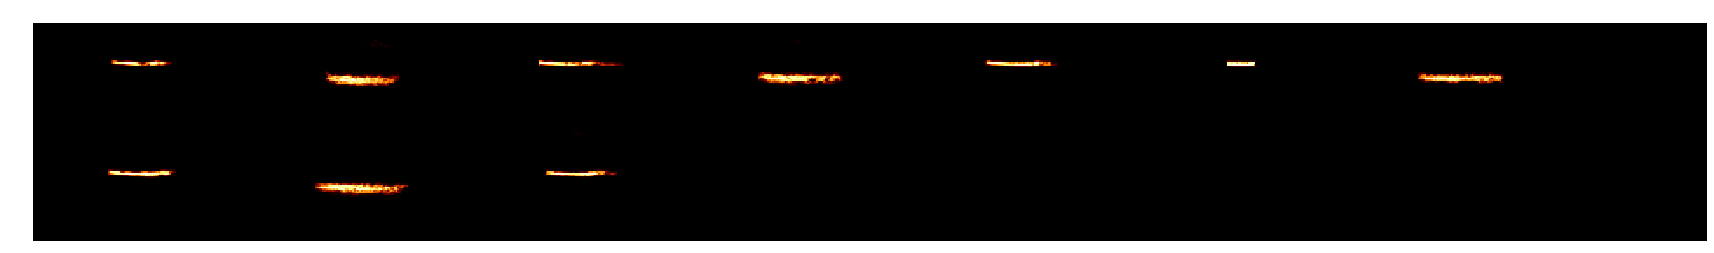

C25 332


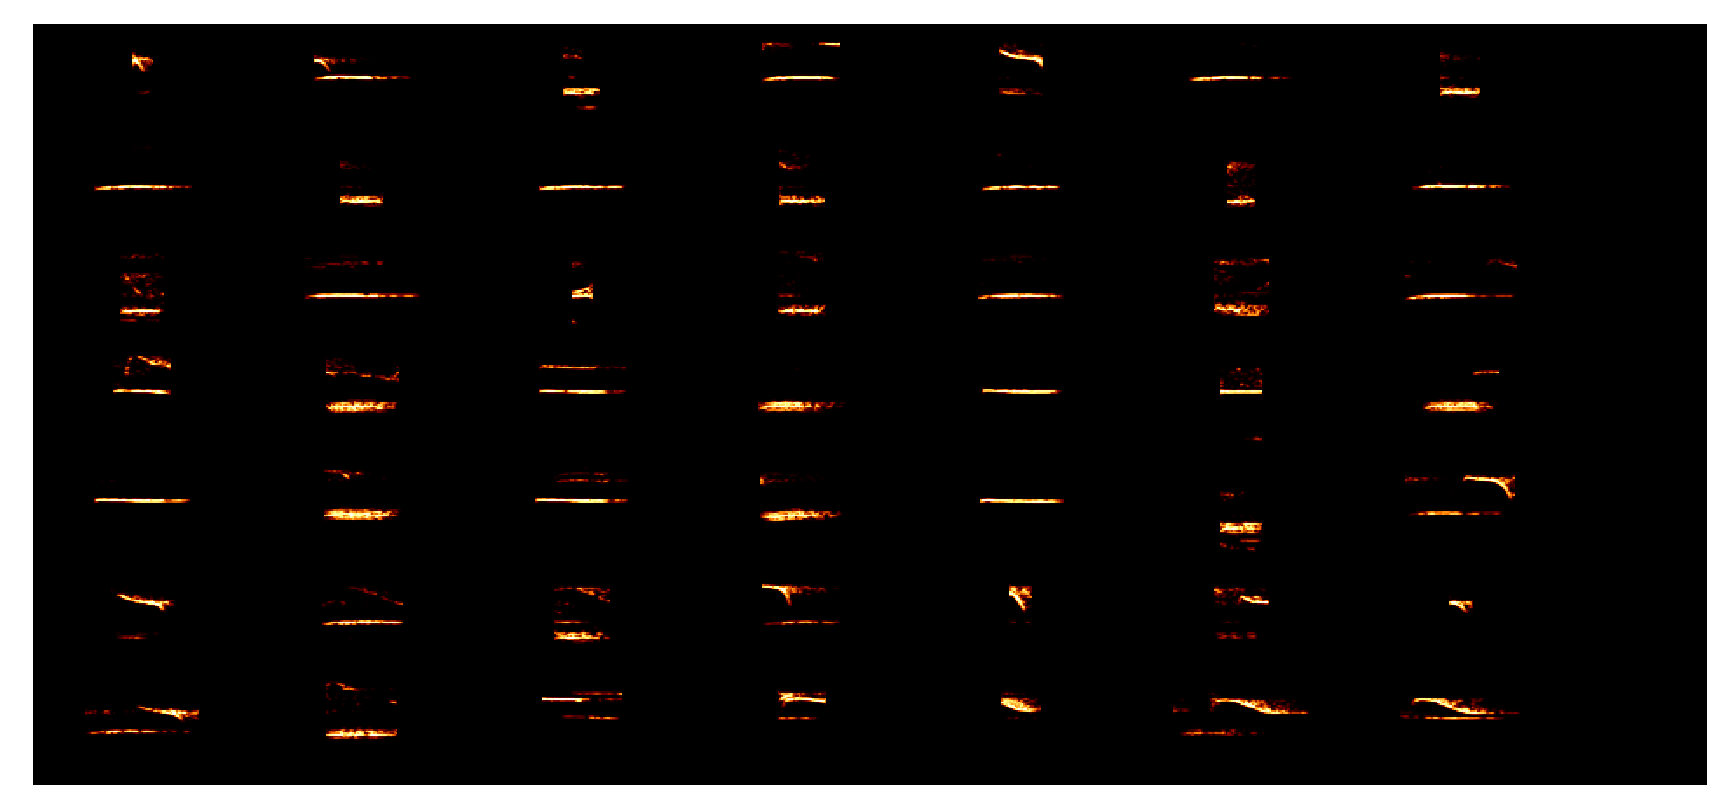

C51 975


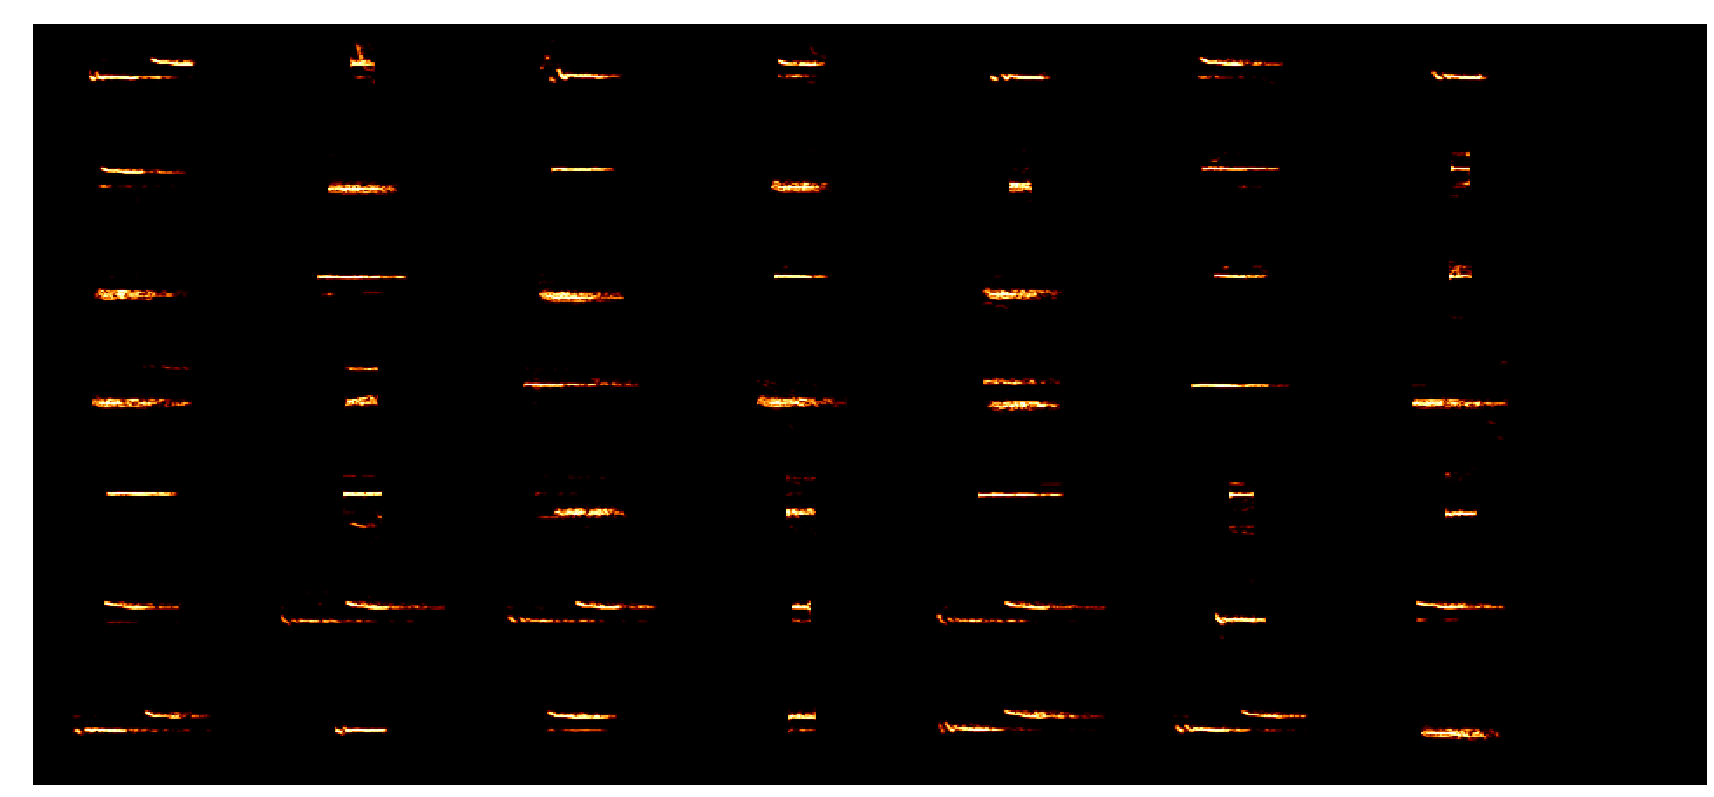

C61A 49


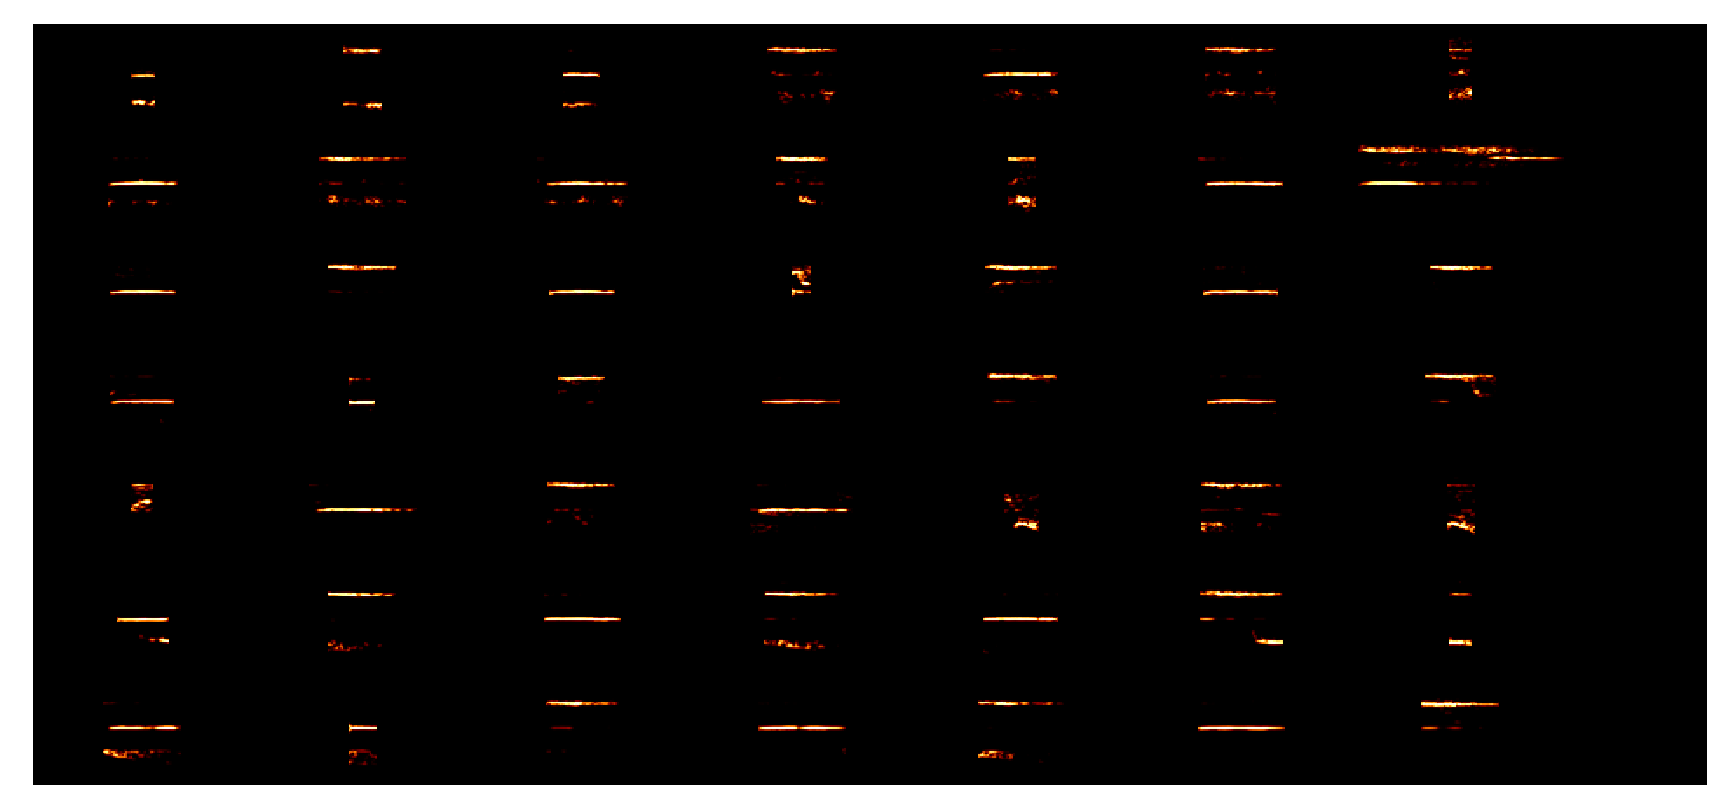

EX120 231


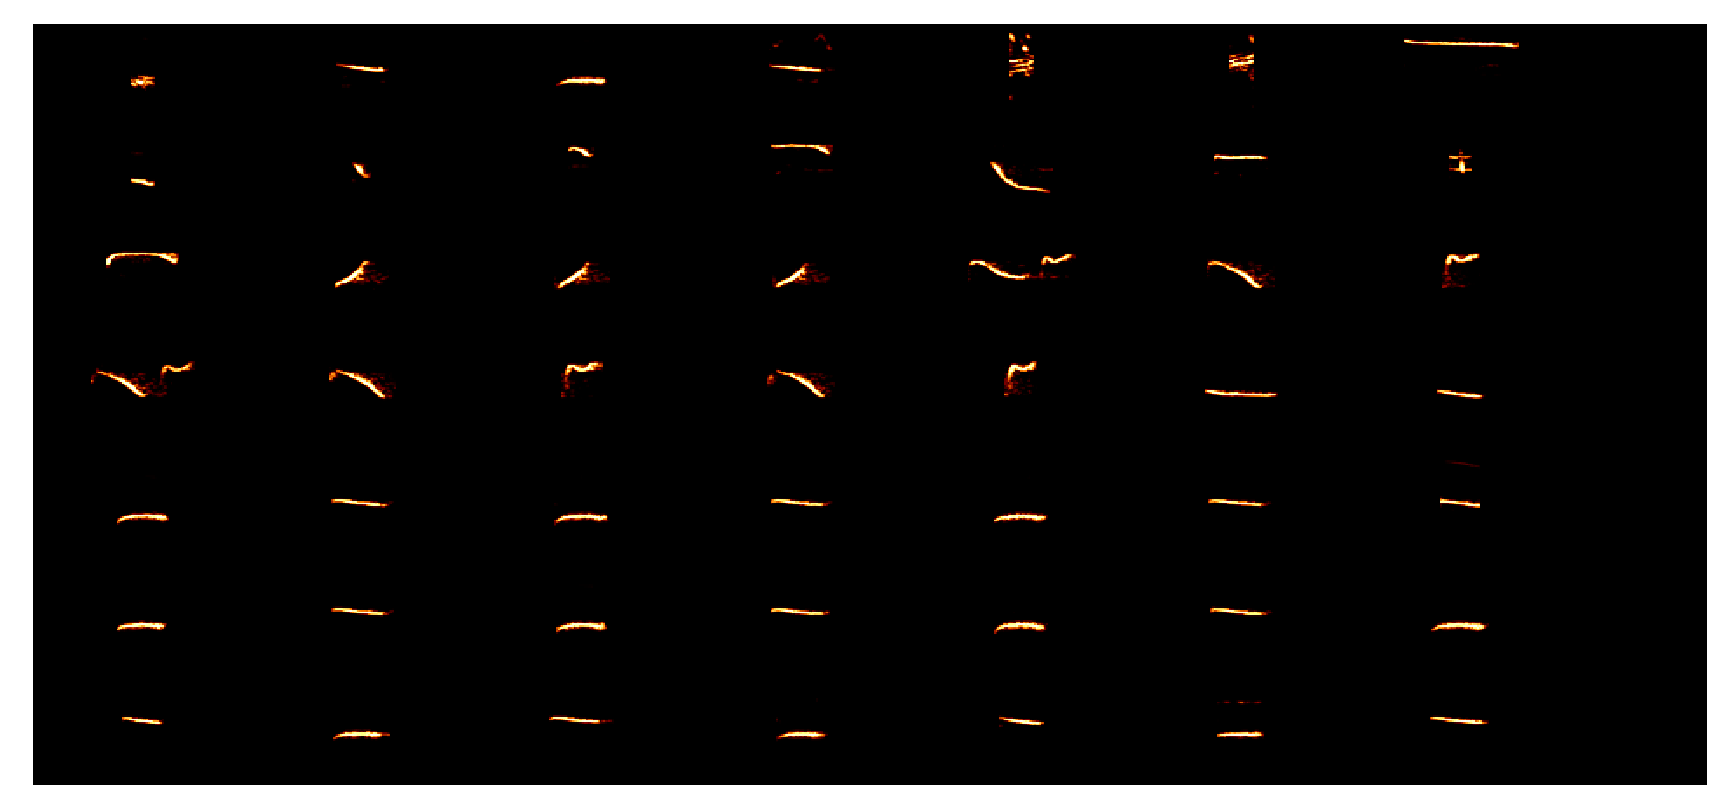

EX14 3625


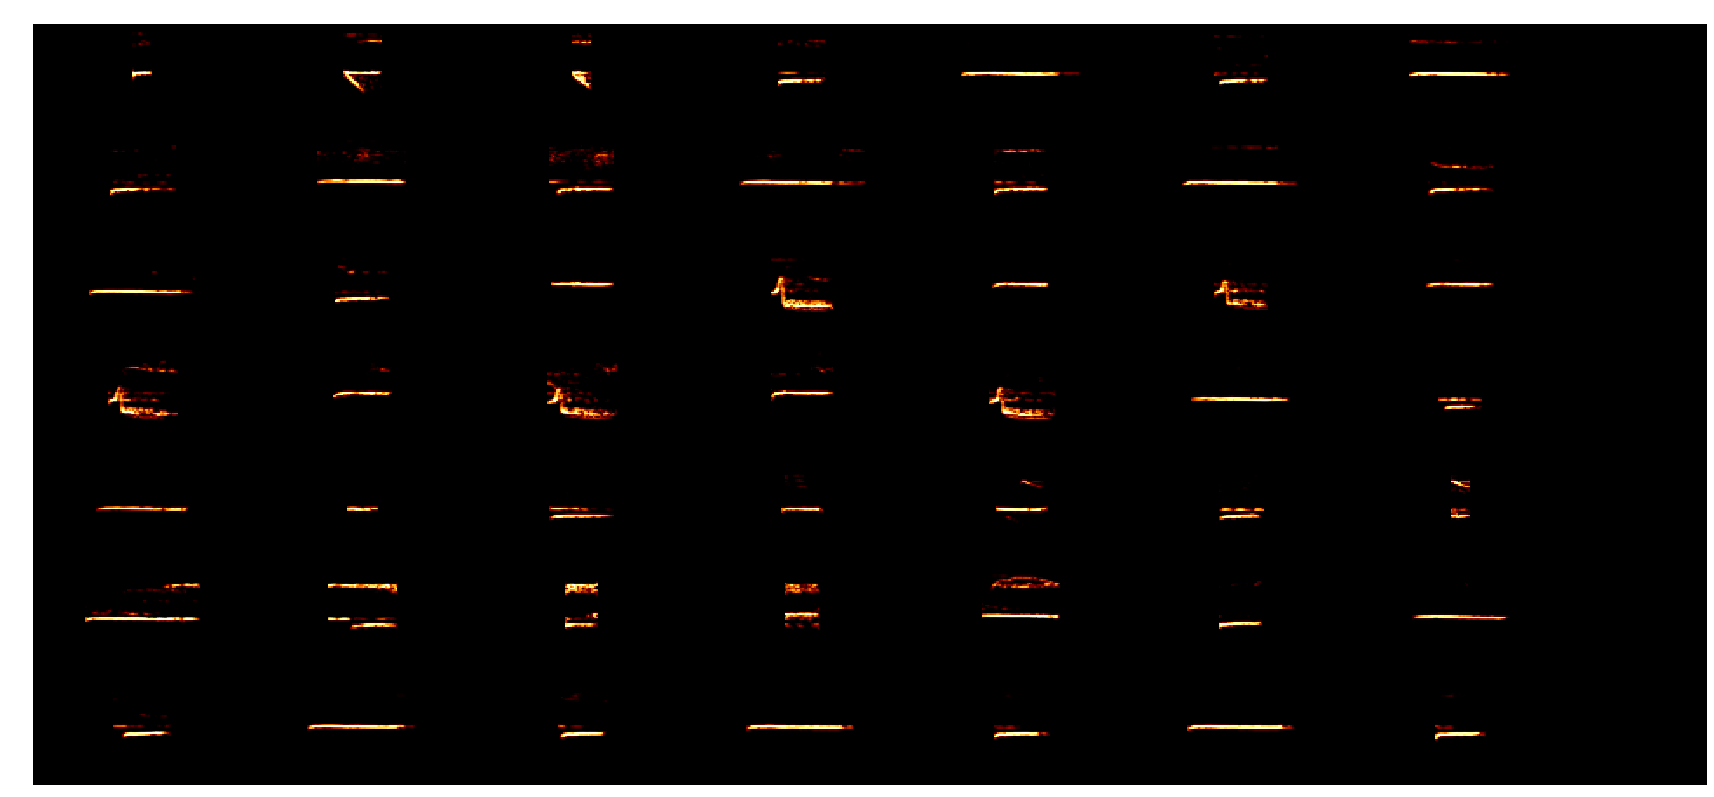

EX65 102


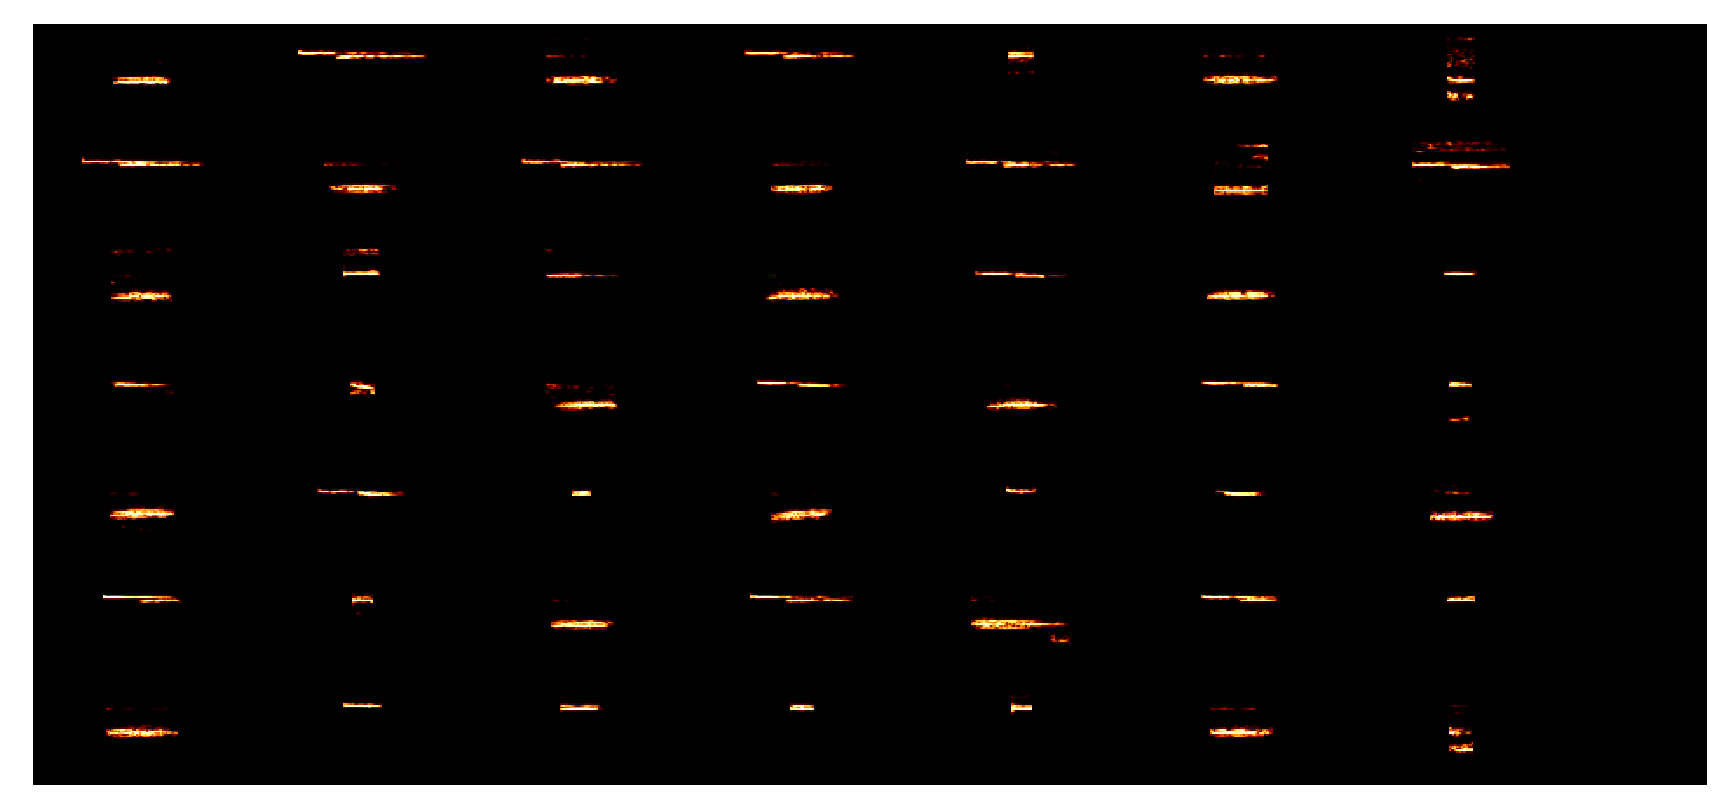

EX74 129


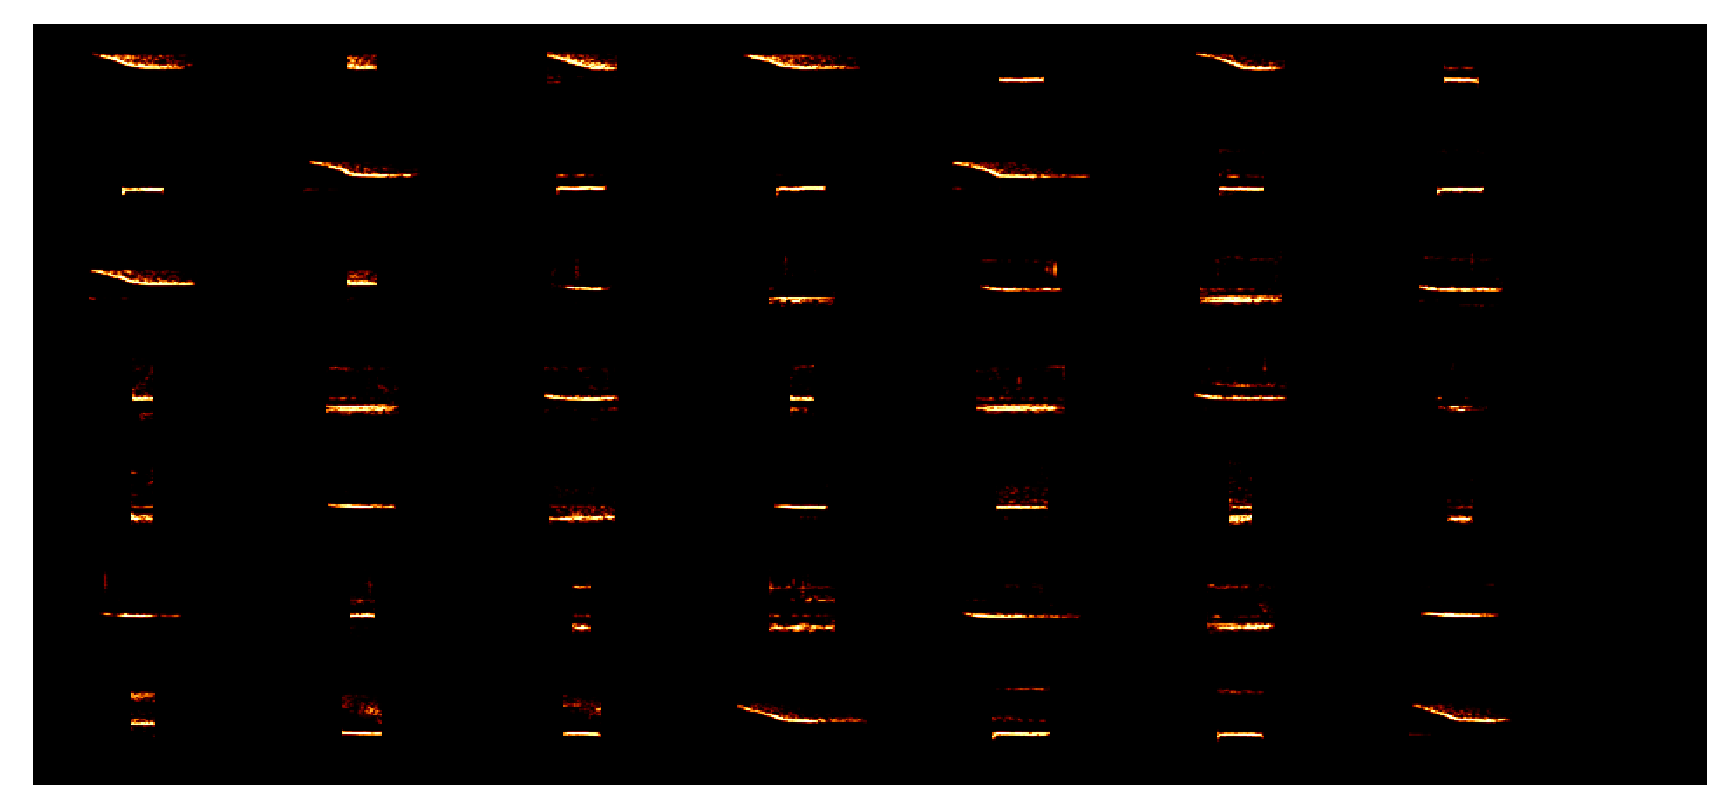

MP2 99


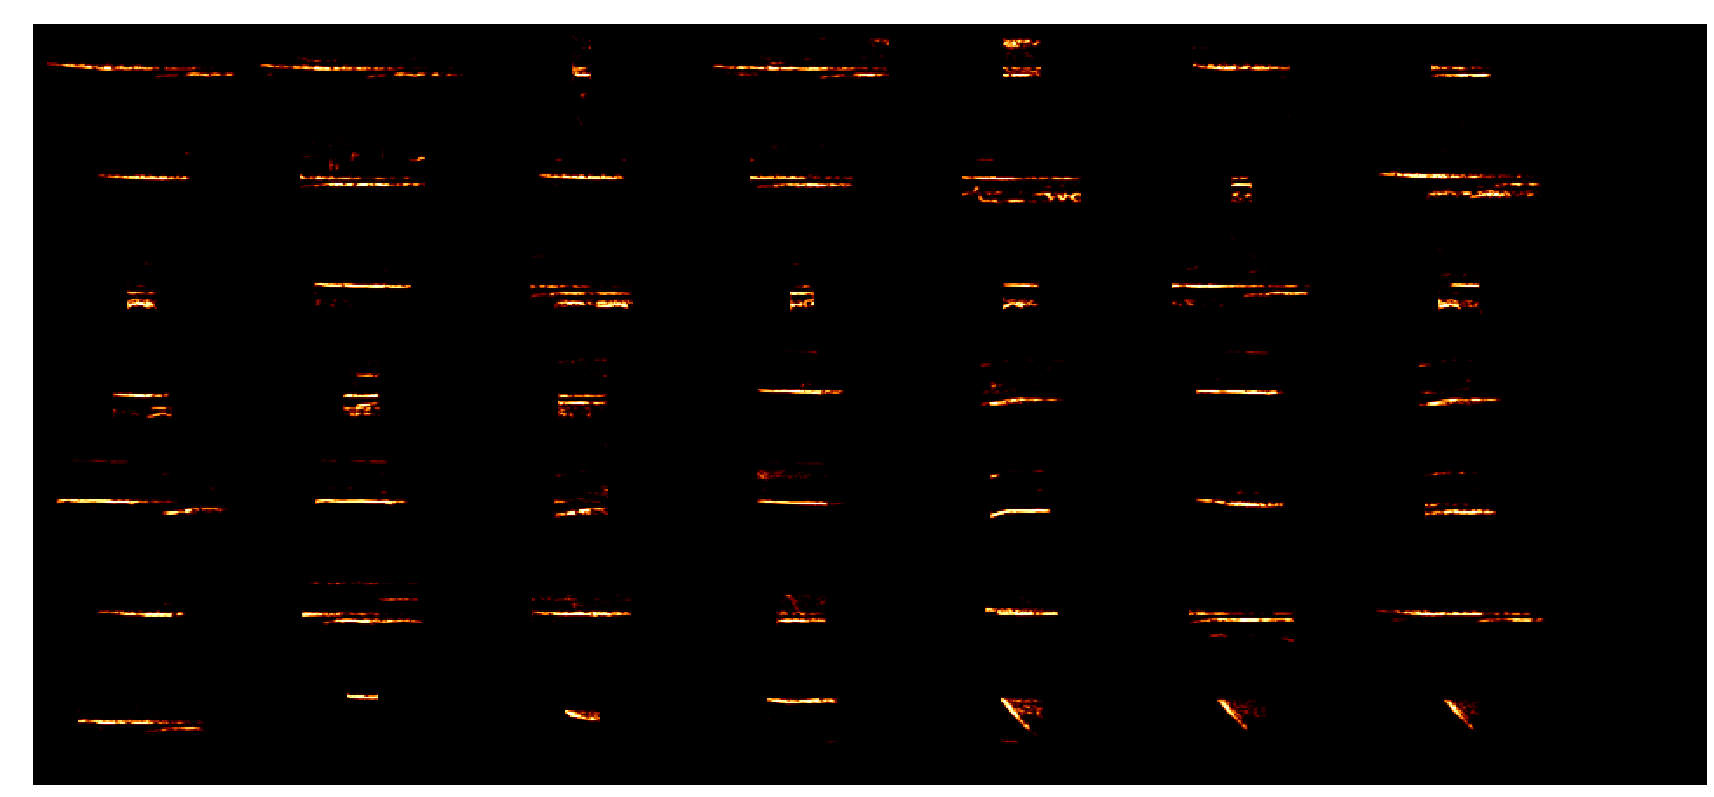

MP48 746


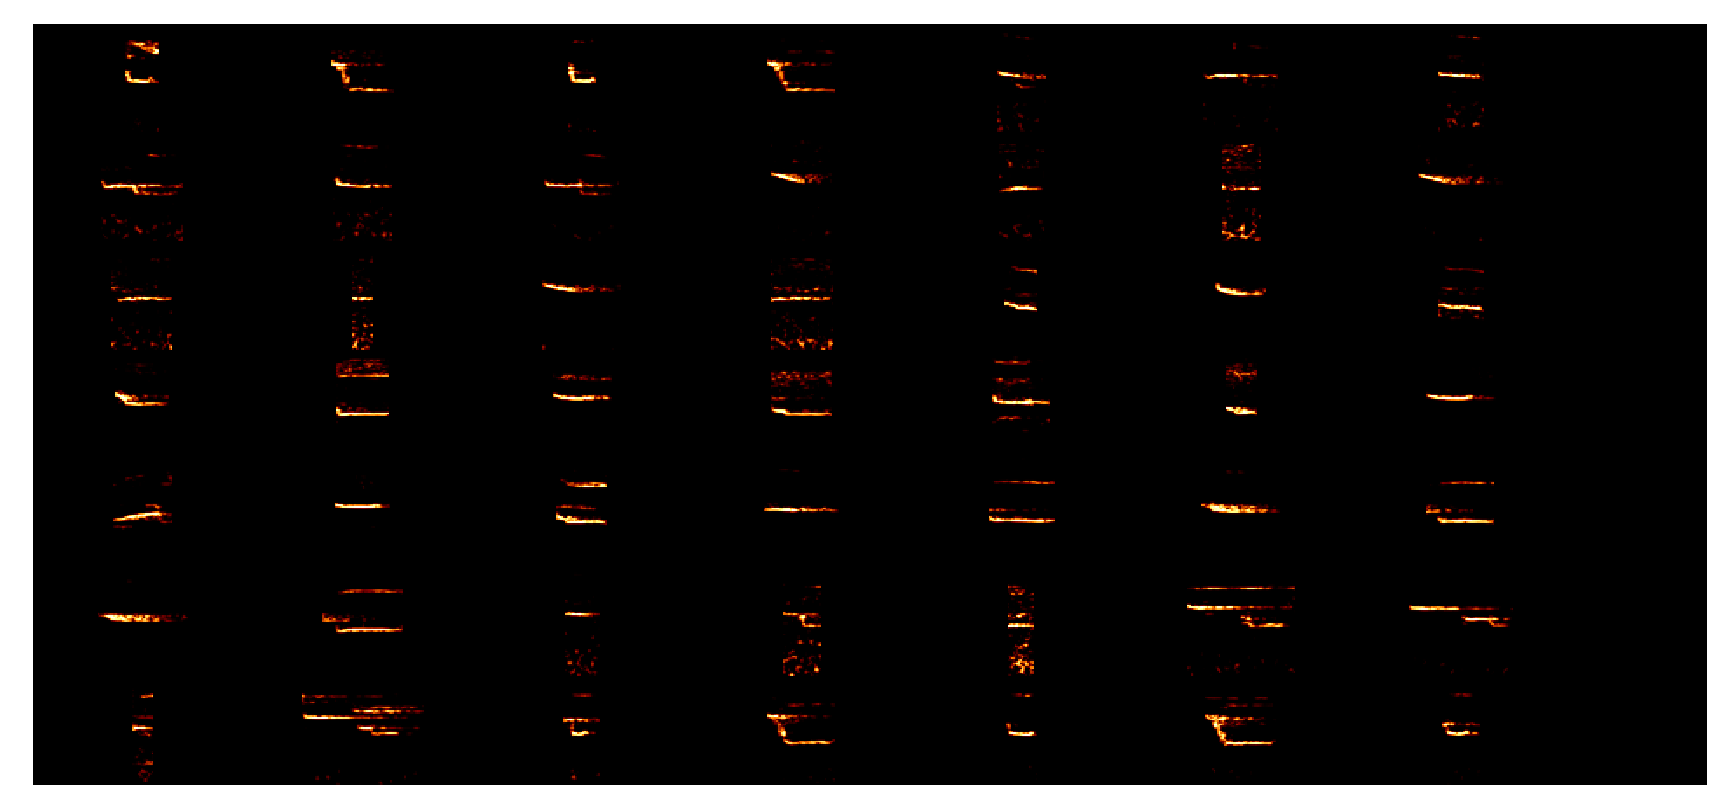

O80 81


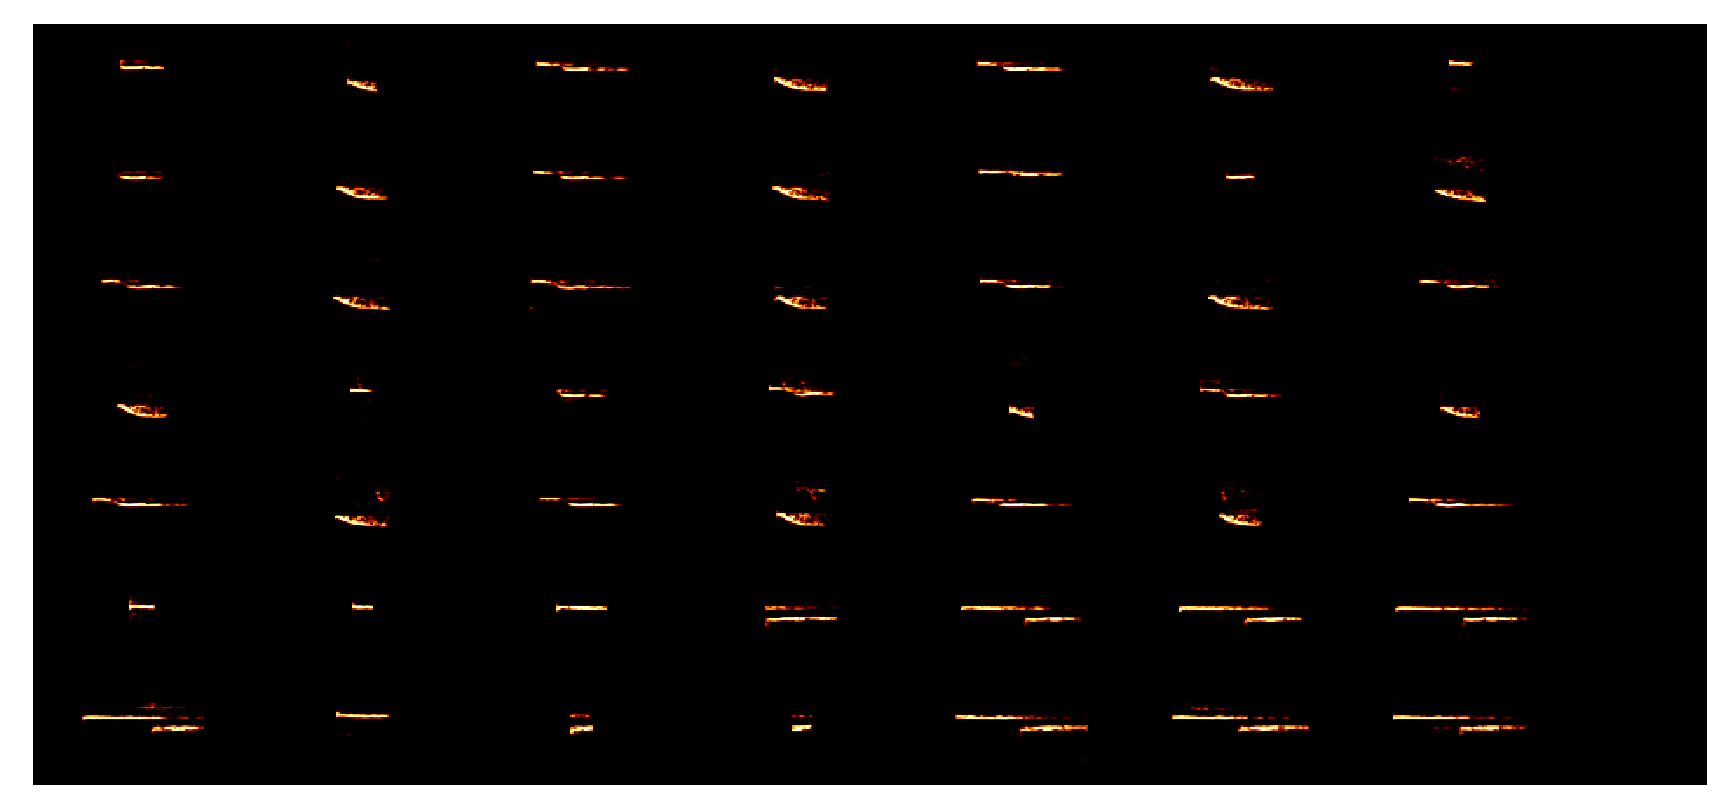

O86 40


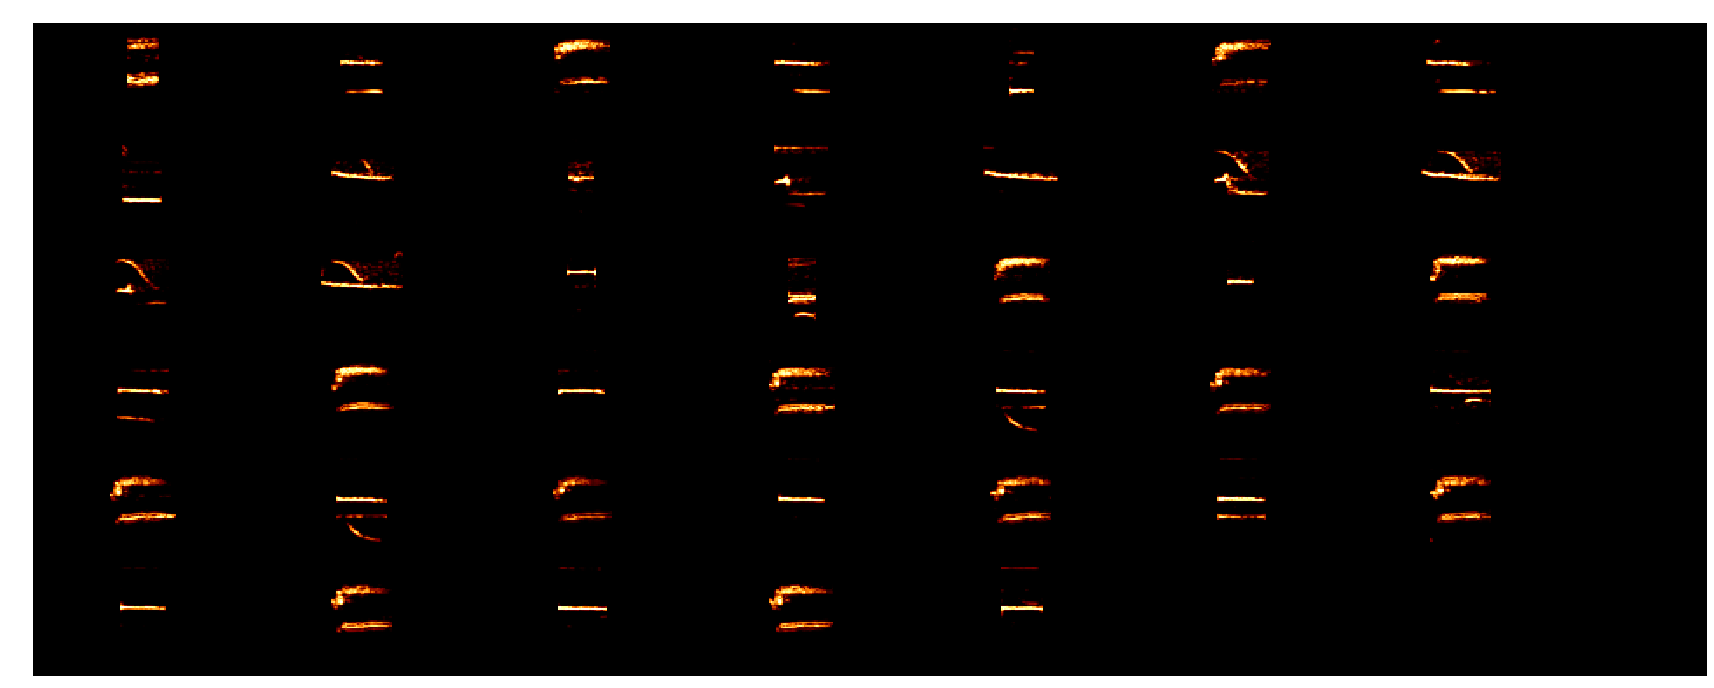

W77 4068


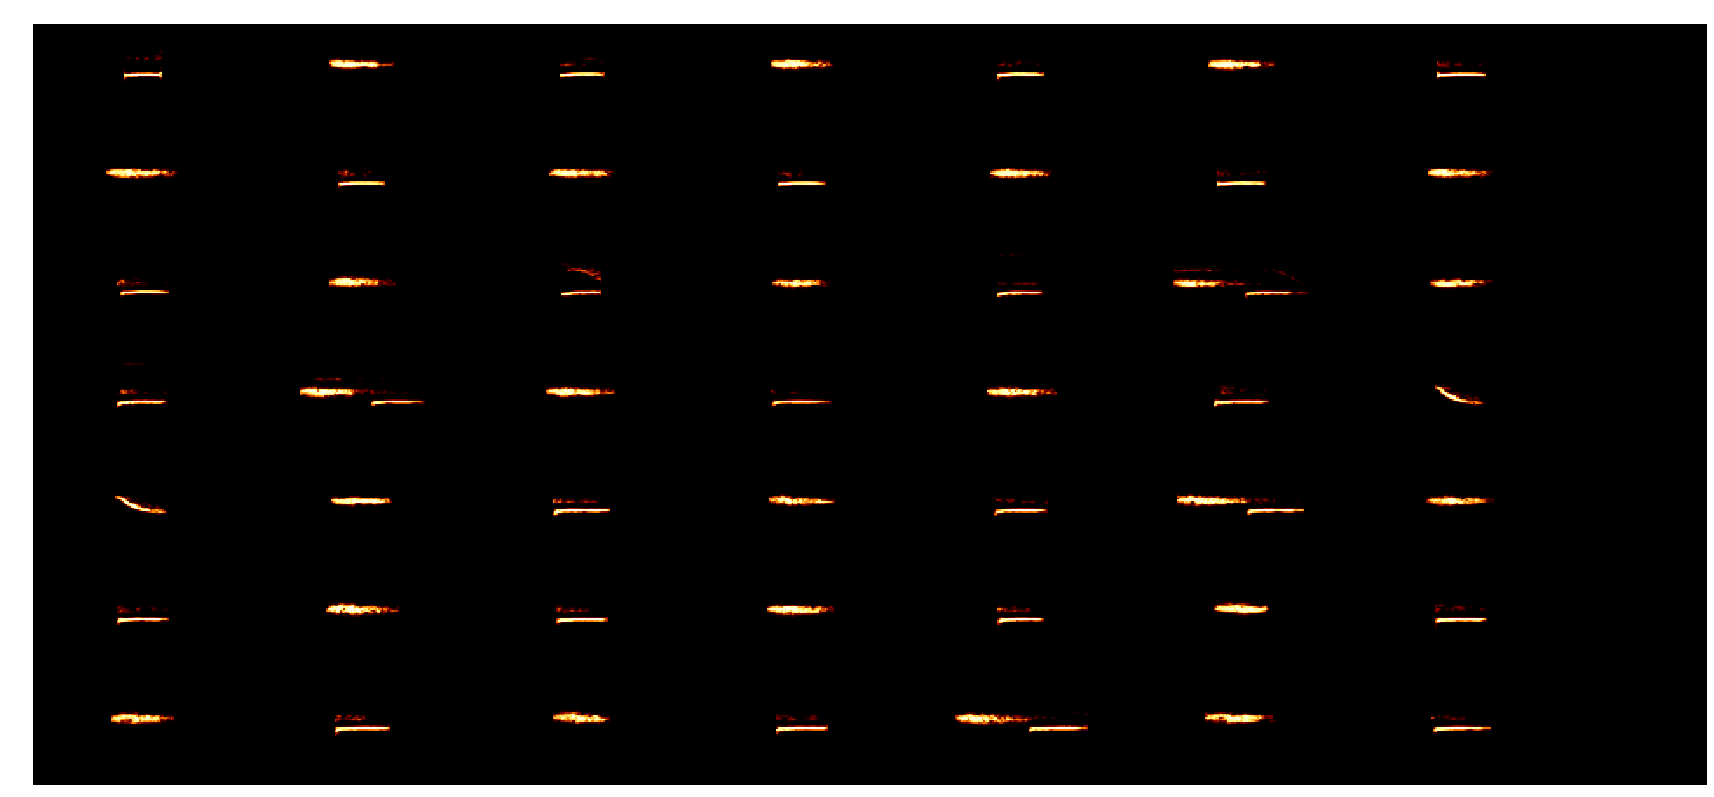

In [15]:
syllable_df.indv.unique()

for indv in np.sort(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array(
        [
            i / np.max(i)
            for i in syllable_df[syllable_df.indv == indv].spectrogram.values
        ]
    )
    specs[specs < 0] = 0
    draw_spec_set(specs, zoom=2, maxrows=7, colsize=15)

### Save entire dataset

In [16]:

save_loc = DATA_DIR / "syllable_dfs" / DATASET_ID / "{}.pickle".format(DATASET_ID)
ensure_dir(save_loc)
syllable_df.drop("audio", 1).to_pickle(save_loc)
